<a href="https://www.kaggle.com/code/mikedelong/python-eda-with-scatter-plots?scriptVersionId=247729704" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/credit-profile-two-wheeler-loan-dataset/credit_data.csv')
df.head()

Age  Gender  Income  Credit Score  Credit History Length  \
0   31    Male   36000           604                    487   
1   25    Male   50000           447                    386   
2   62   Other  178000           850                    503   
3   69  Female   46000           668                    349   
4   52    Male  132000           601                    553   

   Number of Existing Loans  Loan Amount  Loan Tenure Existing Customer  \
0                         5       109373          221                No   
1                         2       150000           89                No   
2                        10        69099          110               Yes   
3                         6       150000          148               Yes   
4                         5       150000          157                No   

           State       City  LTV Ratio Employment Profile  Profile Score  \
0      Karnataka     Mysuru  90.943430           Salaried             77   
1      Karnataka  Bengaluru  91.135253           Salaried             43   
2  Uttar Pradesh     Kanpur  40.000000           Salaried             90   
3      Karnataka  Bengaluru  87.393365      Self-Employed             86   
4      Karnataka     Mysuru  66.158757           Salaried             90   

          Occupation  
0             Doctor  
1  Software Engineer  
2             Banker  
3         Contractor  
4            Teacher

In [2]:
df.nunique().to_frame().T

Age  Gender  Income  Credit Score  Credit History Length  \
0   53       3     201           551                    606   

   Number of Existing Loans  Loan Amount  Loan Tenure  Existing Customer  \
0                        11        55681          348                  2   

   State  City  LTV Ratio  Employment Profile  Profile Score  Occupation  
0     10    23      80874                   5            101          14

<Axes: ylabel='Frequency'>

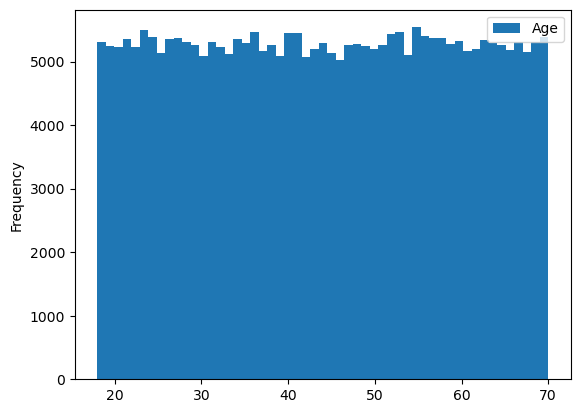

In [3]:
df['Age'].plot.hist(bins=1 + df['Age'].max() - df['Age'].min(), legend=True)

It's interesting that the borrowers have ages that are essentially uniformly distributed.

<Axes: >

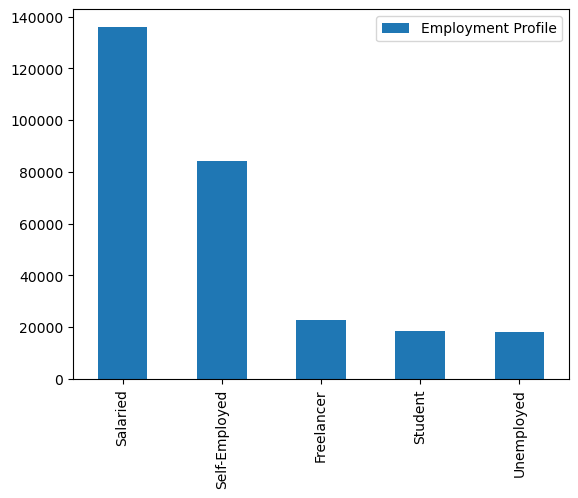

In [4]:
df['Employment Profile'].value_counts().plot(kind='bar', legend=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: >

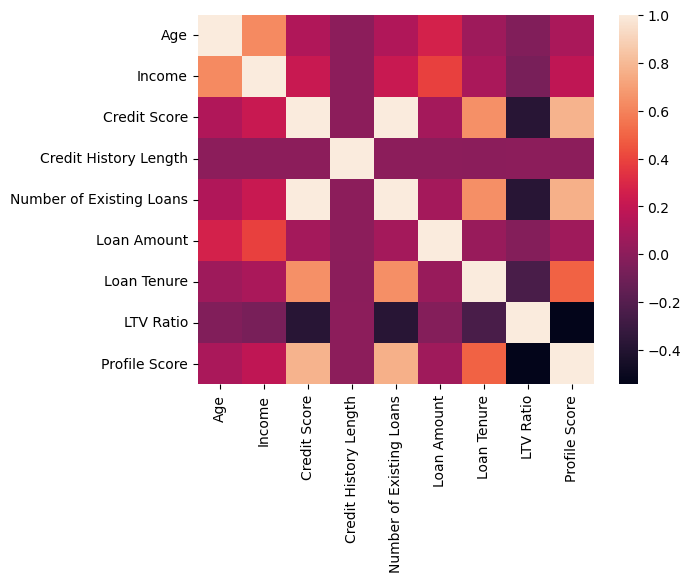

In [5]:
from seaborn import heatmap
heatmap(data=df.corr(numeric_only=True))

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


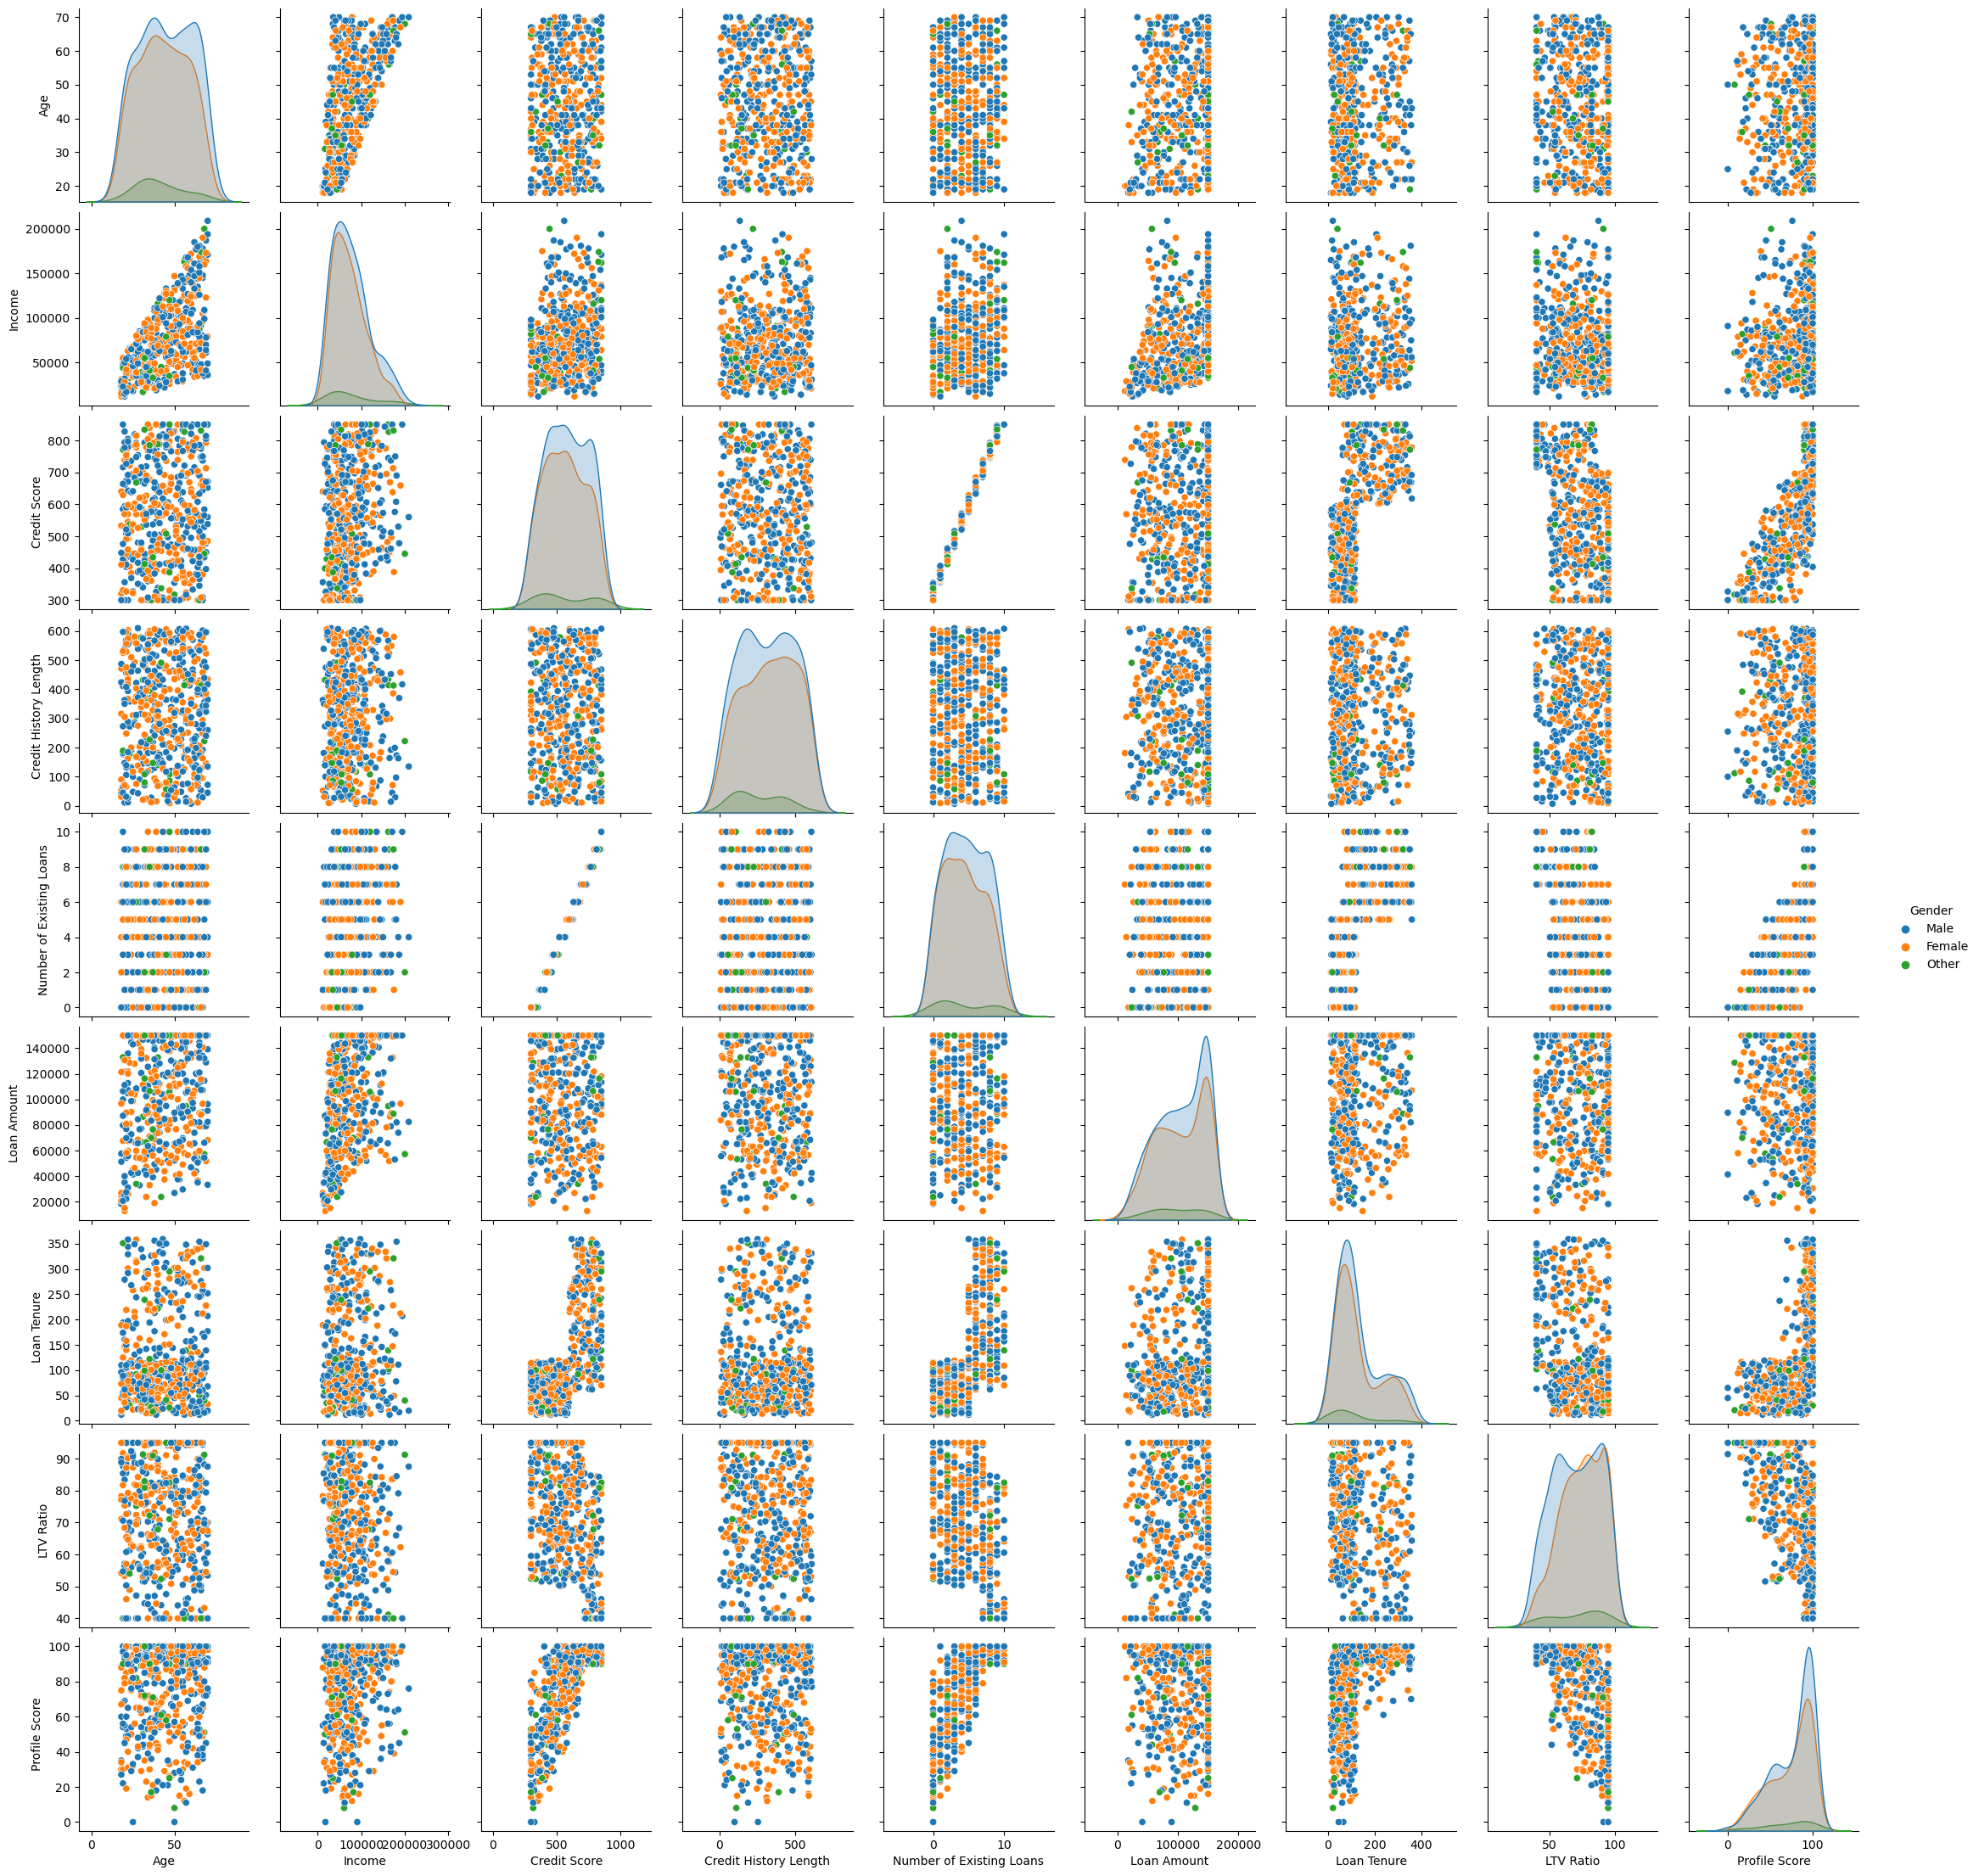

In [6]:
from seaborn import pairplot
sample_size = 500
pairplot(data=df.sample(n=sample_size, random_state=2023), hue='Gender')

There's so much to look into here; we've taken a small sample for performance reasons, and it's possible the small sample size is causing some artifacts.

<Axes: xlabel='LTV Ratio', ylabel='Count'>

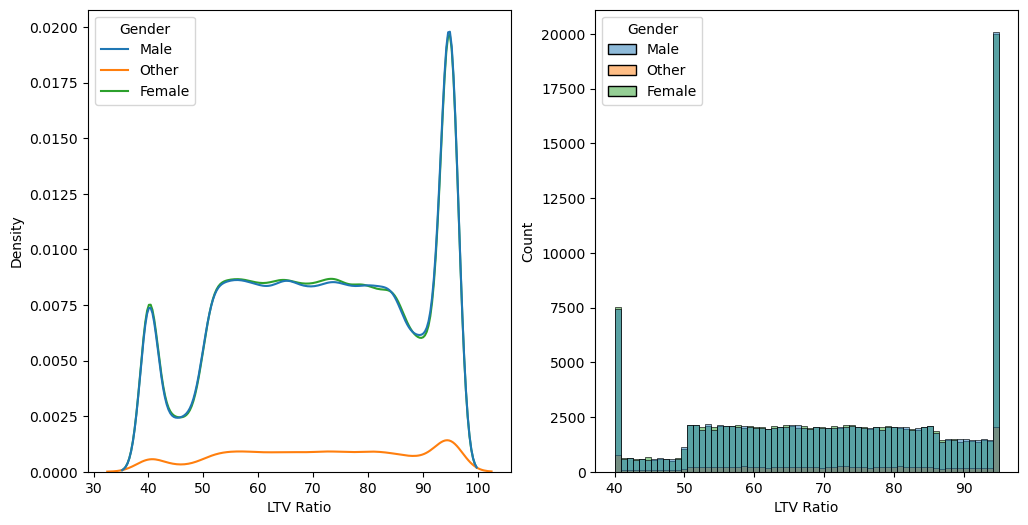

In [7]:
from matplotlib.pyplot import subplots
from seaborn import histplot
from seaborn import kdeplot
_, ax = subplots(figsize=(12, 6), ncols=2)
kdeplot(ax=ax[0], data=df, x='LTV Ratio', hue='Gender')
histplot(ax=ax[1], data=df, x='LTV Ratio', hue='Gender')

The gender slices are very close; that LTV curve just looks weird.

<Axes: xlabel='Credit Score', ylabel='Count'>

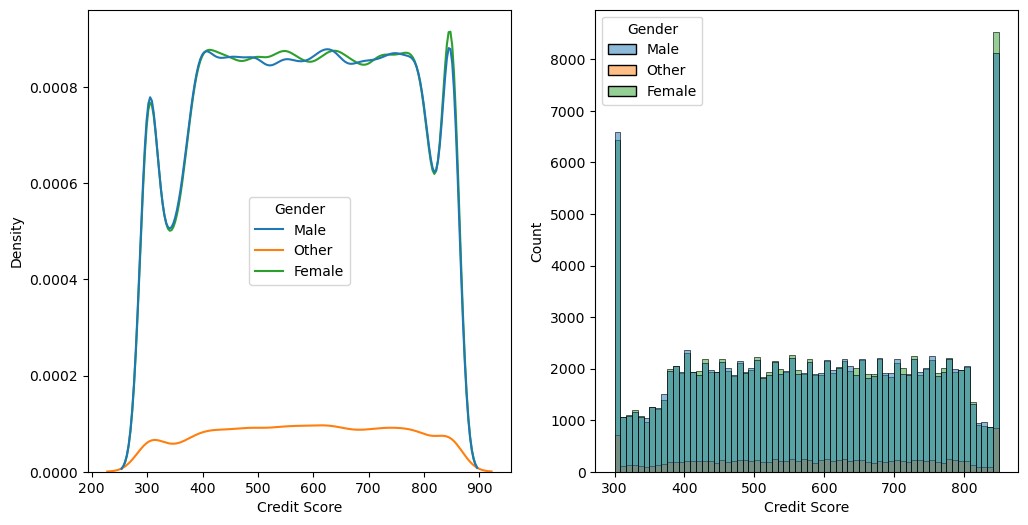

In [8]:
_, ax = subplots(figsize=(12, 6), ncols=2)
kdeplot(ax=ax[0], data=df, x='Credit Score', hue='Gender')
histplot(ax=ax[1], data=df, x='Credit Score', hue='Gender')

<Axes: xlabel='Age', ylabel='Count'>

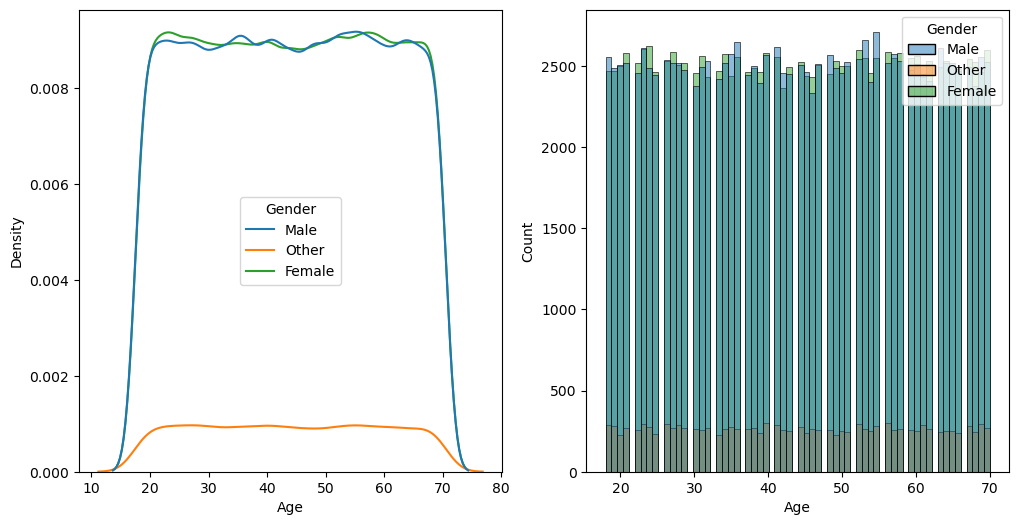

In [9]:
_, ax = subplots(figsize=(12, 6), ncols=2)
kdeplot(ax=ax[0], data=df, x='Age', hue='Gender')
histplot(ax=ax[1], data=df, x='Age', hue='Gender')

In [10]:
from plotly.express import scatter
from plotly import io

io.renderers.default = 'iframe'
scatter(data_frame=df.sample(n=10 * sample_size, random_state=2023),
        x='Number of Existing Loans', y='Credit Score', color='Employment Profile').show()

Wow. These two factors are essentially the same thing; and almost nobody who is unemployed gets a loan of any size.

In [11]:
scatter(data_frame=df.sample(n=10 * sample_size, random_state=2023), y='Profile Score', x='Credit Score', color='Employment Profile').show()

Weird how students seem to be concentrated in the high/high corner.

<Axes: xlabel='Credit Score', ylabel='Profile Score'>

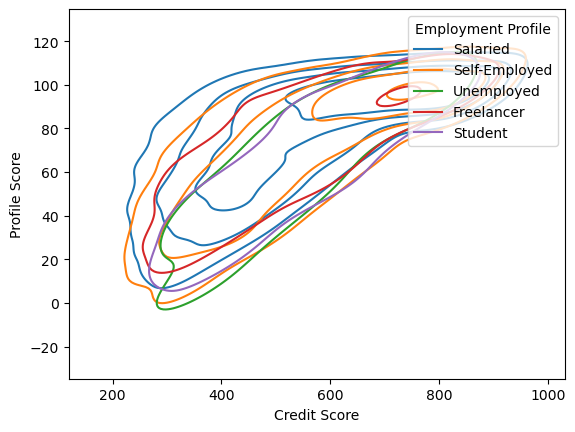

In [12]:
kdeplot(data=df.sample(n=10 * sample_size, random_state=2023), x='Credit Score', y='Profile Score', hue='Employment Profile', levels=5)

This seems more likely, as the peaks of the distributions look more similar.

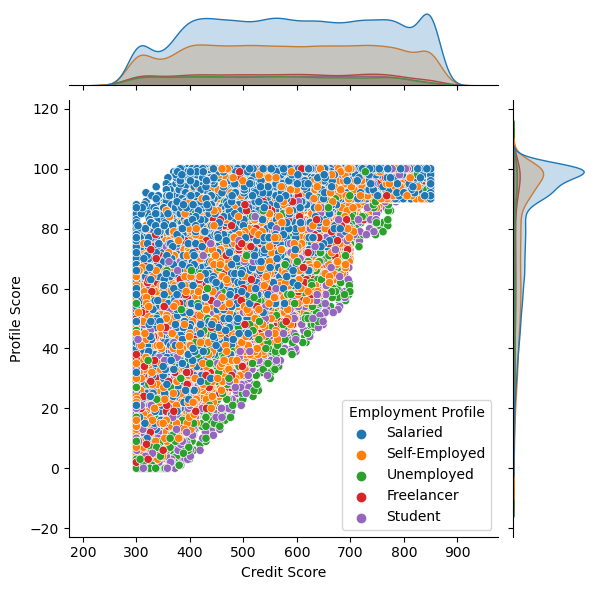

In [13]:
from seaborn import jointplot
jointplot(data=df.sample(n=len(df)//4, random_state=2023), x='Credit Score', y='Profile Score', hue='Employment Profile')

In [14]:
from sklearn.model_selection import train_test_split
test_columns = [item for item, value in df.dtypes.to_dict().items() if str(value) in {'float64', 'int64'} if item != 'Profile Score']
X_train, X_test, y_train, y_test = train_test_split(df[test_columns], df['Profile Score'], test_size=0.2, random_state=2023)
print(test_columns)
print(len(X_train))

['Age', 'Income', 'Credit Score', 'Credit History Length', 'Number of Existing Loans', 'Loan Amount', 'Loan Tenure', 'LTV Ratio']
223884


In [15]:
# with verbose = 1 the model will tell us when it is done
# fitting this model will take about three minutes for 100 estimators
from sklearn.ensemble import RandomForestRegressor
n_estimators = 100
model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=1, random_state=2023, verbose=1, )
model.fit(X=X_train, y=y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.9min finished


RandomForestRegressor(n_jobs=1, random_state=2023, verbose=1)

In [16]:
y_pred = model.predict(X=X_test)
print('{:6.3f}'.format(model.score(X=X_test, y=y_test)))
result_df = pd.DataFrame(data={'true': y_test.tolist(), 'predicted': y_pred.tolist()},).sort_values(by='true').reset_index(drop=True)
result_df['difference'] = result_df['true'] - result_df['predicted']
result_df['error'] = result_df['difference'].apply(abs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 0.977


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


In [17]:
result_df.head(n=5)

true  predicted  difference  error
0     0       6.04       -6.04   6.04
1     0       7.48       -7.48   7.48
2     0       2.66       -2.66   2.66
3     0       4.26       -4.26   4.26
4     0       5.01       -5.01   5.01

Our model is producing nonzero predictions where the true value is zero.

In [18]:
result_df.tail(n=5)

true  predicted  difference  error
55967   100      97.31        2.69   2.69
55968   100      99.77        0.23   0.23
55969   100      99.17        0.83   0.83
55970   100      99.46        0.54   0.54
55971   100      99.67        0.33   0.33

And we have differences on the high end too.

Let's use a jointplot to look at our errors.

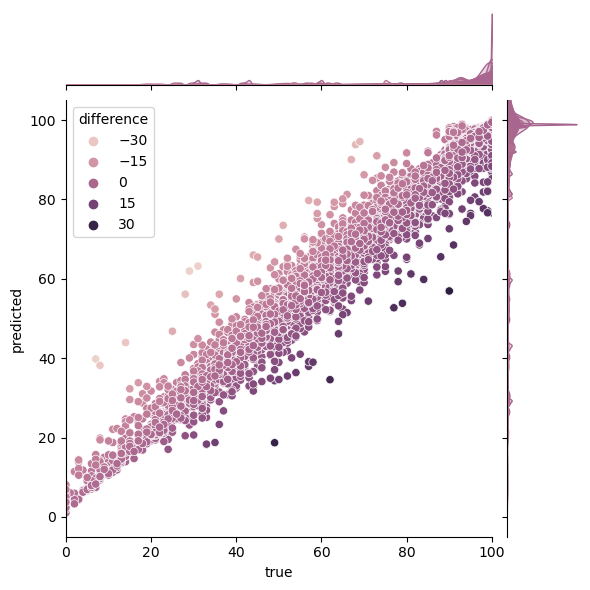

In [19]:
from seaborn import jointplot
jointplot(data=result_df.sample(n=min(10000, len(result_df)), random_state=2023, replace=False),
          hue='difference', x='true', xlim=[0, 100], y='predicted', ylim=[-5, 105])

The spikes in the predicted values suggest we have errors that are concentrated. Let's look at the distribution of errors.

<Axes: xlabel='difference', ylabel='Density'>

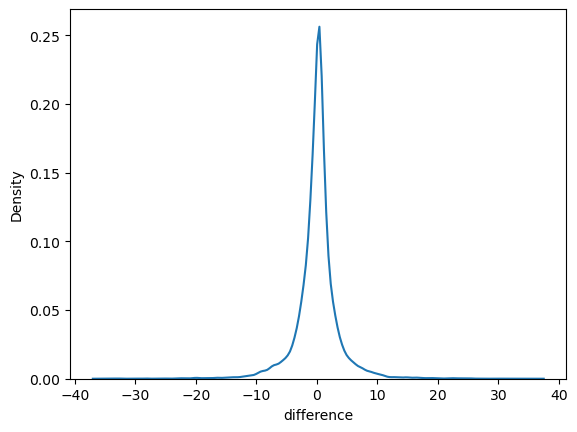

In [20]:
from seaborn import kdeplot
kdeplot(data=result_df, x='difference')

Sure enough most of the time our errors are small; there are a significant number of small errors, and a nonzero number of errors that are 20% or more.

The spikes in the estimated KDE suggest our prediction error are concentrated, so let's sort the differences and plot them.

<Axes: >

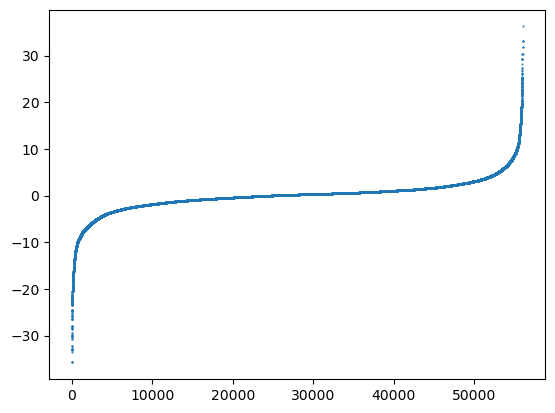

In [21]:
result_df.sort_values(by=['difference']).reset_index(drop=True)['difference'].plot(kind='line', linestyle='None',
                                                                                                 marker='.', markersize=1)

Yikes.

In [22]:
test_df = df.loc[X_test.index.tolist()].copy()
test_df['predicted'] = y_pred
test_df['difference'] = test_df['Profile Score'] - test_df['predicted']
print('difference: min: {:5.2f} max: {:5.2f}'.format(test_df['difference'].min(), test_df['difference'].max()) )
test_df['error'] = test_df['difference'].apply(abs)
test_df.head()

difference: min: -35.78 max: 36.25


Age  Gender  Income  Credit Score  Credit History Length  \
209571   61    Male   71000           796                    139   
9444     37    Male   31000           438                    256   
26625    22  Female   28000           300                    603   
67101    57    Male  111000           850                    608   
172872   59    Male  148000           570                    413   

        Number of Existing Loans  Loan Amount  Loan Tenure Existing Customer  \
209571                         9        82887           95               Yes   
9444                           2        76987          116                No   
26625                          0       131074           60                No   
67101                         10       113589          331               Yes   
172872                         4       150000           74                No   

            State       City  LTV Ratio Employment Profile  Profile Score  \
209571  Telangana  Hyderabad  69.538730           Salaried            100   
9444      Gujarat  Dhulagori  53.516393           Salaried             86   
26625   Telangana  Hyderabad  67.067929      Self-Employed             51   
67101       Delhi  New Delhi  45.998650           Salaried             93   
172872  Rajasthan    Udaipur  78.164625           Salaried            100   

       Occupation  predicted  difference  error  
209571    Teacher      99.90        0.10   0.10  
9444       Banker      86.19       -0.19   0.19  
26625      Farmer      48.71        2.29   2.29  
67101      Banker      96.35       -3.35   3.35  
172872    Teacher      93.78        6.22   6.22

Let's look at the mean difference broken down by the categorical columns and see if it looks concentrated anywhere.

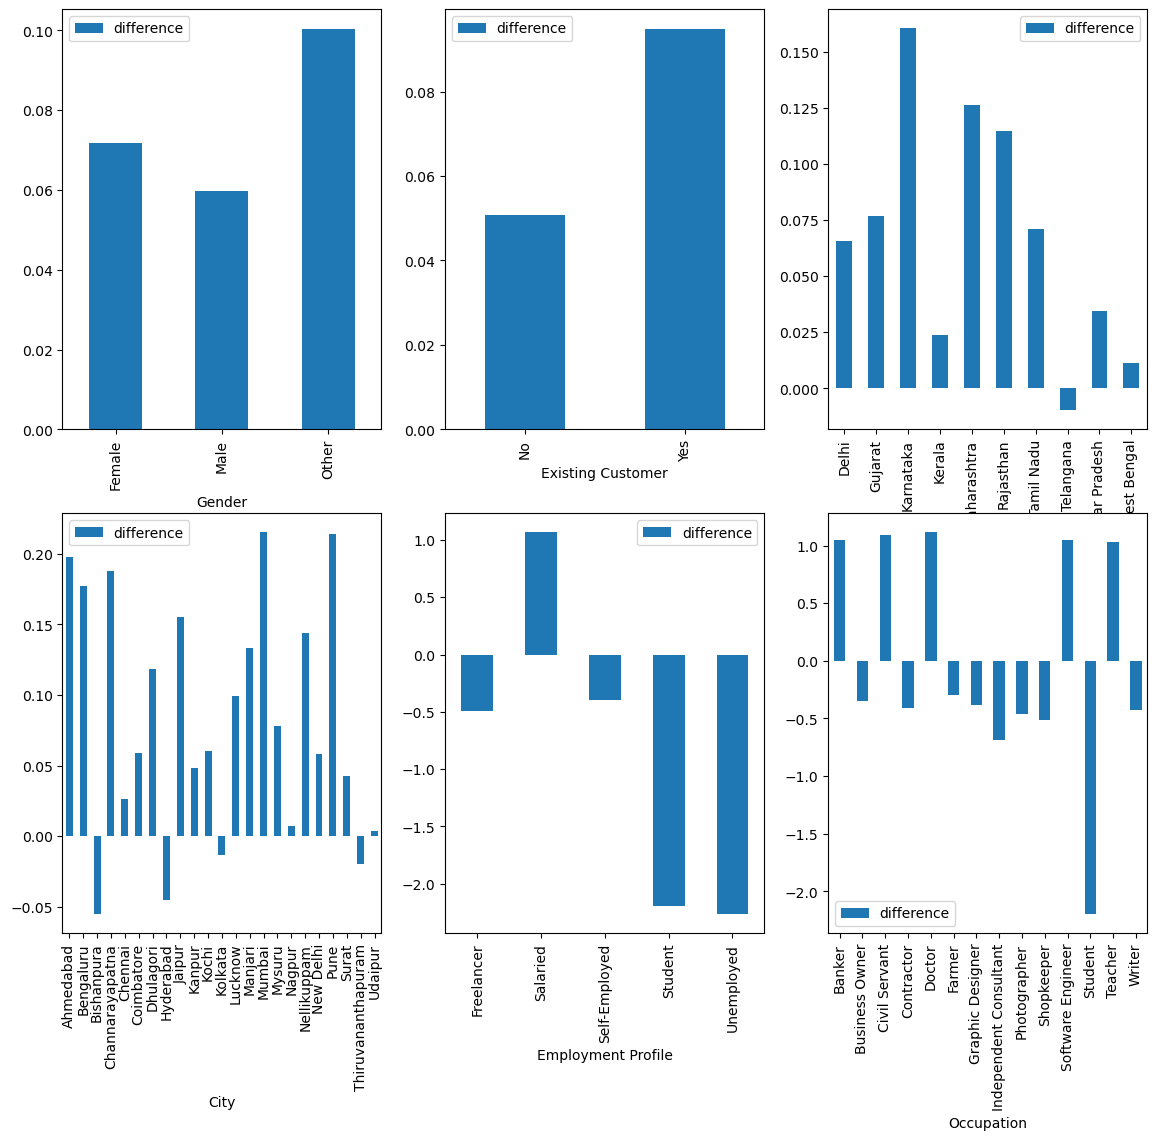

In [23]:
_, ax = subplots(figsize=(14, 12), nrows=2, ncols=3)
for index, column in enumerate([item for item in df.columns if item not in test_columns and item != 'Profile Score']):
    test_df[[column, 'difference']].groupby(column).mean().plot(ax=ax.ravel()[index], kind='bar', sharey=False)

Most of the time the difference is essentially random: the mean difference is less than 0.2 points for gender, prior relationship, or geography, but it can be as high as 2.0 for the employment/occupation variables. In other words if we want to replicate the underlying Profile Score model we need to find a way to incorporate at least one of these two variables.

In [24]:
dummies_df = pd.get_dummies(columns=['Employment Profile', 'Occupation'], data = df[test_columns + ['Employment Profile', 'Occupation']])
dummies_test = dummies_df.loc[X_test.index.tolist()]
dummies_train = dummies_df.loc[X_train.index.tolist()]
dummies_model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=1, random_state=2023, verbose=1, )
dummies_model.fit(X=dummies_train, y=y_train)
print('{:6.3f}'.format(dummies_model.score(X=dummies_test, y=y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 0.982


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


difference: min: -30.02 max: 29.29


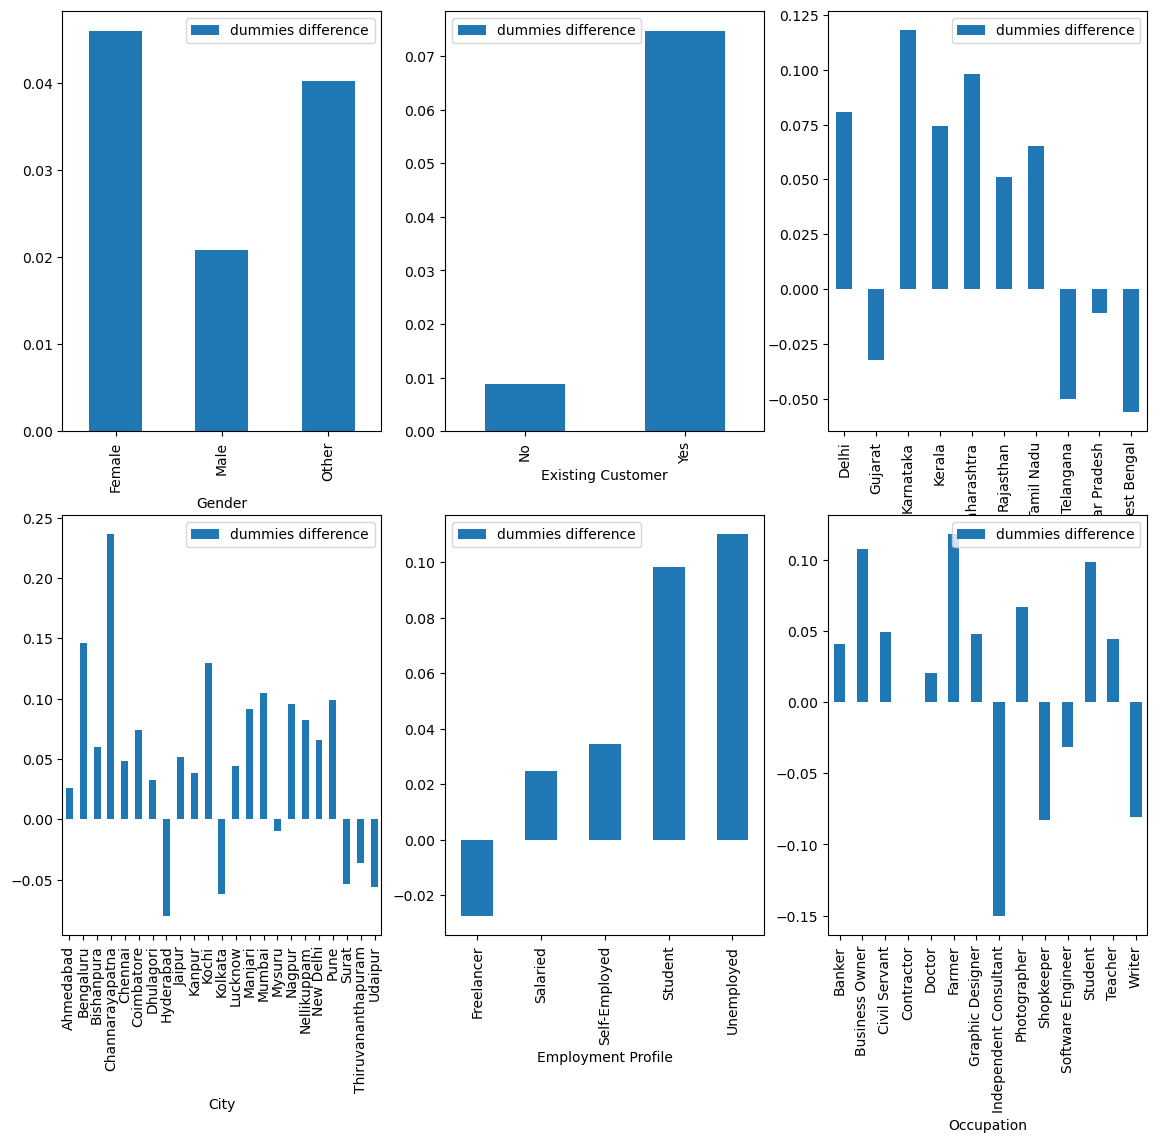

In [25]:
test_df['dummies predicted'] = dummies_model.predict(X=dummies_test)
test_df['dummies difference'] = test_df['Profile Score'] - test_df['dummies predicted']
print('difference: min: {:5.2f} max: {:5.2f}'.format(test_df['dummies difference'].min(), test_df['dummies difference'].max()) )
_, ax = subplots(figsize=(14, 12), nrows=2, ncols=3)
for index, column in enumerate([item for item in df.columns if item not in test_columns and item != 'Profile Score']):
    test_df[[column, 'dummies difference']].groupby(column).mean().plot(ax=ax.ravel()[index], kind='bar', sharey=False)

We want to see how the differences have changed; we can graph them sorted, but the relative differences from the plot above are hard to see; we get a better picture if we plot the new differences against the old differences on a point basis.

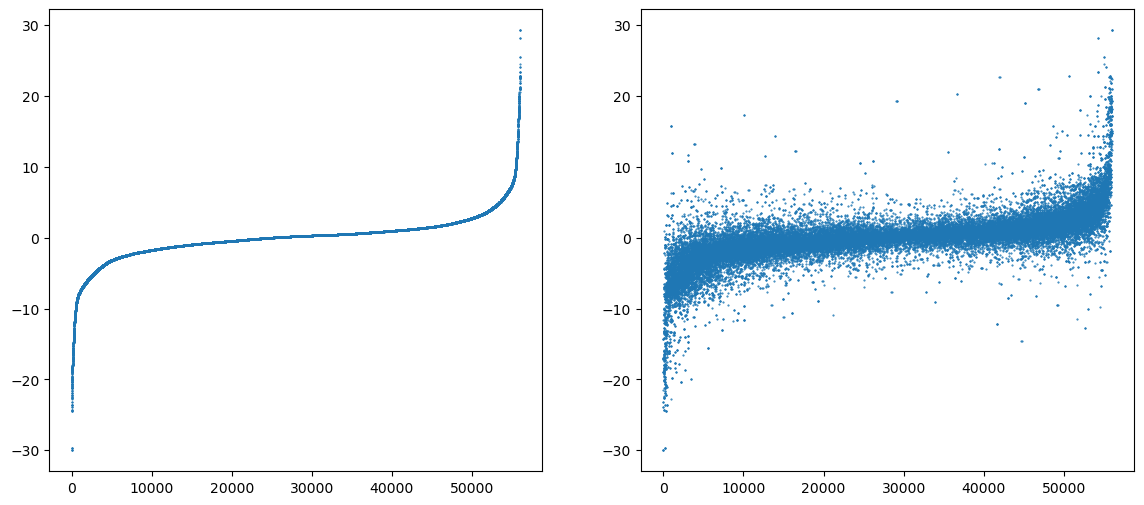

In [26]:
_, ax = subplots(figsize=(14, 6), ncols=2)
for index, by in enumerate(['dummies difference', 'difference']):
    test_df.sort_values(by=[by]).reset_index(drop=True)['dummies difference'].plot(ax=ax[index], kind='line', linestyle='None', marker='.', markersize=1)

We can also plot the differences from the two models against each other and break them out by our two categorical variables to see how adding the dummies to the model has changed the differences in the aggregate.

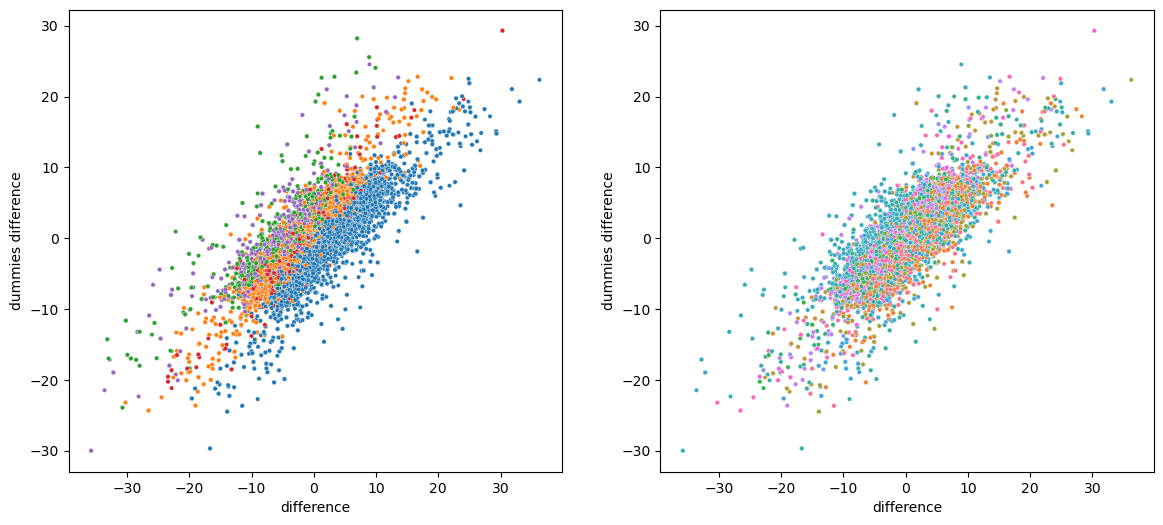

In [27]:
from seaborn import scatterplot
_, ax = subplots(figsize=(14, 6), ncols=2)
for index, hue in enumerate(['Employment Profile', 'Occupation']):
    scatterplot(ax=ax[index], data=test_df, hue=hue, legend=False, s=10, x='difference', y='dummies difference', )